# BYU Locating Flagellar Motors

## Submission Generation Notebook

This is the fourth and final notebook in a series for the BYU Locating Bacterial Flagellar Motors 2025 Kaggle challenge. This notebook creates predictions on test data and generates the competition submission file.

### Notebook Series:
1. **[Parse Data](https://www.kaggle.com/code/andrewjdarley/parse-data)**: Extracting and preparing 2D slices containing motors to make a YOLO dataset
2. **[Visualize Data](https://www.kaggle.com/code/andrewjdarley/visualize-data)**: Exploratory data analysis and visualization of annotated motor locations
3. **[Train YOLO](https://www.kaggle.com/code/andrewjdarley/train-yolo)**: Fine tuning an YOLOv8 object detection model on the prepared dataset
4. **Submission Notebook (Current)**: Running inference and generating submission files 

## Important: Offline Execution
This notebook is designed to run in an offline environment. The Ultralytics YOLOv8 package has been installed using the offline installation method from [this reference notebook](https://www.kaggle.com/code/itsuki9180/ultralytics-for-offline-install). This implementation was brilliant. I use my own copy as input that works effectively the same as the original.

## About this Notebook

This submission notebook implements an optimized inference pipeline that:

1. **Model Loading**: Loads the best trained YOLOv8 weights from the training notebook
2. **GPU Optimization**: Configures CUDA optimizations, half-precision inference, and memory management
3. **Parallel Processing**: Uses CUDA streams and batch processing for efficient GPU utilization
4. **3D Detection**: Processes each slice to locate motors
5. **Non-Maximum Suppression**: Applies 3D NMS to cluster and merge detections across slices
6. **Submission Generation**: Creates the final CSV file with predicted motor coordinates

The code includes advanced optimizations like dynamic batch sizing based on available GPU memory, preloading batches while processing the current batch, and GPU profiling to monitor performance. The CONCENTRATION parameter can be adjusted to trade off between processing speed and detection accuracy. The only reason you'd ever modify CONCENTRATION is just to verify submission capability since full submission takes a few hours.

In [1]:
!tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
!pip install --no-index --find-links=./packages ultralytics
!rm -rf ./packages

./packages/
./packages/networkx-3.4.2-py3-none-any.whl
./packages/fsspec-2025.2.0-py3-none-any.whl
./packages/python_dateutil-2.9.0.post0-py2.py3-none-any.whl
./packages/jinja2-3.1.5-py3-none-any.whl
./packages/pyparsing-3.2.1-py3-none-any.whl
./packages/charset_normalizer-3.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/ultralytics_thop-2.0.14-py3-none-any.whl
./packages/nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl
./packages/urllib3-2.3.0-py3-none-any.whl
./packages/nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl
./packages/pytz-2025.1-py2.py3-none-any.whl
./packages/MarkupSafe-3.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/cycler-0.12.1-py3-none-any.whl
./packages/nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl
./packages/nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl
./package

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
No motor detected in tomo_53e048_z0194_y0666_x0542.jpg
No motor detected in tomo_53e048_z0188_y0666_x0542.jpg
No motor detected in tomo_53e048_z0186_y0666_x0542.jpg
No motor detected in tomo_672101_z0106_y0290_x0581.jpg
No motor detected in tomo_53e048_z0190_y0666_x0542.jpg
No motor detected in tomo_4077d8_z0076_y0100_x0225.jpg
No motor detected in tomo_53e048_z0187_y0666_x0542.jpg
No motor detected in tomo_53e048_z0191_y0666_x0542.jpg
No motor detected in tomo_3e7407_z0253_y0348_x0692.jpg
No motor detected in tomo_37dd38_z0183_y0303_x0593.jpg
No motor detected in tomo_3e7407_z0245_y0350_x0725.jpg
No motor detected in tomo_37dd38_z0181_y0303_x0593.jpg
No motor detected in tomo_53e

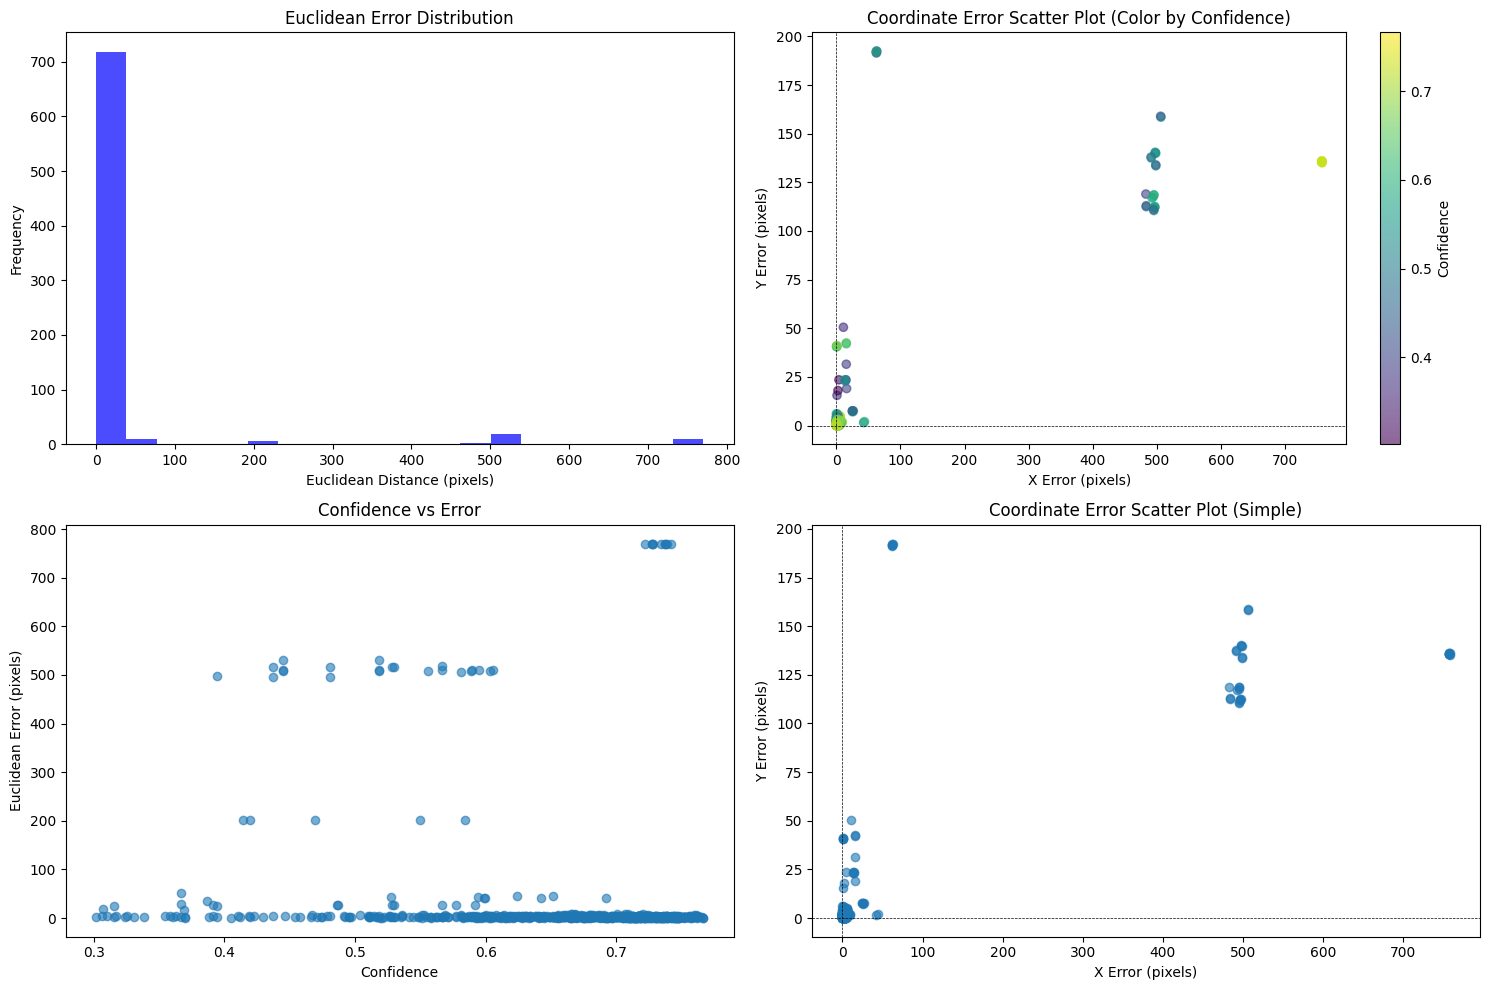


Saved results to 'yolo_error_analysis_results.csv' and 'yolo_error_stats_summary.csv'


In [2]:
import os
import cv2 
import numpy as np
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Paths
model_path = "/kaggle/input/yolov8m-without-attention/runs/detect/motor_detector/weights/best.pt"
val_images_dir = "/kaggle/input/parse-data/yolo_dataset/images/val/"
val_labels_dir = "/kaggle/input/parse-data/yolo_dataset/labels/val/"

# Load YOLO model
model = YOLO(model_path)

results = []

for image_name in os.listdir(val_images_dir):
    if not image_name.endswith(('.jpg', '.png', '.jpeg')):
        continue
    
    # --- Ground Truth ---
    label_path = os.path.join(val_labels_dir, image_name.rsplit('.', 1)[0] + '.txt')
    try:
        with open(label_path, 'r') as f:
            gt_data = f.readline().strip().split()  # class x_center y_center w h
    except FileNotFoundError:
        print(f"Label missing for {image_name}, skipping")
        continue
    
    # --- Image Loading ---
    img_path = os.path.join(val_images_dir, image_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load {image_name}, skipping")
        continue
    
    img_height, img_width = img.shape[:2]
    
    # Convert YOLO format (normalized) to pixel coordinates
    x_gt = float(gt_data[1]) * img_width
    y_gt = float(gt_data[2]) * img_height

    # --- Prediction ---
    preds = model(img, verbose=False)[0]
    if len(preds.boxes) == 0:
        print(f"No motor detected in {image_name}")
        continue
    
    best_box = preds.boxes
    best_box_conf = best_box.conf.cpu().numpy()
    best_idx = np.argmax(best_box_conf)
    if best_box_conf[best_idx] < 0.3:
        continue
    
    x1, y1, x2, y2 = map(int, best_box.xyxy[0].cpu().numpy())
    x_pred = (x1 + x2) / 2
    y_pred = (y1 + y2) / 2
    
    euclidean_dist = np.sqrt((x_gt - x_pred)**2 + (y_gt - y_pred)**2)
    
    # --- Store Results ---
    results.append({
        'image': image_name,
        'x_gt': x_gt, 'y_gt': y_gt,
        'x_pred': x_pred, 'y_pred': y_pred,
        'error_x': abs(x_gt - x_pred),
        'error_y': abs(y_gt - y_pred),
        'euclidean_dist': euclidean_dist,
        'confidence': best_box_conf[best_idx],
        'class_id': best_box.cls[best_idx].item()
    })

# After processing all images...
if results:
    results_df = pd.DataFrame(results)
    
    # Calculate statistics
    stats = {
        'MAE_X': results_df['error_x'].mean(),
        'MAE_Y': results_df['error_y'].mean(),
        'MSE_X': np.mean(results_df['error_x']**2),
        'MSE_Y': np.mean(results_df['error_y']**2),
        'RMSE_X': np.sqrt(np.mean(results_df['error_x']**2)),
        'RMSE_Y': np.sqrt(np.mean(results_df['error_y']**2)),
        'Avg_Euclidean': results_df['euclidean_dist'].mean(),
        'MSE_Euclidean': np.mean(results_df['euclidean_dist']**2),
        'RMSE_Euclidean': np.sqrt(np.mean(results_df['euclidean_dist']**2)),
        'Avg_Confidence': results_df['confidence'].mean()
    }
    
    # Print statistics
    print("\n=== Coordinate-wise Errors ===")
    print(f"MAE (X): {stats['MAE_X']:.2f} pixels")
    print(f"MAE (Y): {stats['MAE_Y']:.2f} pixels")
    print(f"MSE (X): {stats['MSE_X']:.2f} px²")
    print(f"MSE (Y): {stats['MSE_Y']:.2f} px²")
    print(f"RMSE (X): {stats['RMSE_X']:.2f} pixels")
    print(f"RMSE (Y): {stats['RMSE_Y']:.2f} pixels")
    
    print("\n=== Combined Position Errors ===")
    print(f"Average Euclidean Distance: {stats['Avg_Euclidean']:.2f} pixels")
    print(f"MSE (Euclidean): {stats['MSE_Euclidean']:.2f} px²") 
    print(f"RMSE (Euclidean): {stats['RMSE_Euclidean']:.2f} pixels")
    print(f"\nAverage Confidence: {stats['Avg_Confidence']:.2f}")

    # Enhanced Visualizations
    plt.figure(figsize=(15, 10))
    
    # 1. Error distribution (original plot)
    plt.subplot(2, 2, 1)
    plt.hist(results_df['euclidean_dist'], bins=20, alpha=0.7, color='blue')
    plt.xlabel('Euclidean Distance (pixels)')
    plt.ylabel('Frequency')
    plt.title('Euclidean Error Distribution')
    
    # 2. Error scatter plot with confidence (enhanced)
    plt.subplot(2, 2, 2)
    plt.scatter(results_df['error_x'], results_df['error_y'], 
               c=results_df['confidence'], alpha=0.6, cmap='viridis')
    plt.colorbar(label='Confidence')
    plt.xlabel('X Error (pixels)')
    plt.ylabel('Y Error (pixels)')
    plt.title('Coordinate Error Scatter Plot (Color by Confidence)')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    
    # 3. Confidence vs Error (new plot)
    plt.subplot(2, 2, 3)
    plt.scatter(results_df['confidence'], results_df['euclidean_dist'], alpha=0.6)
    plt.xlabel('Confidence')
    plt.ylabel('Euclidean Error (pixels)')
    plt.title('Confidence vs Error')
    
    # 4. Class distribution (if multiple classes)
    if len(results_df['class_id'].unique()) > 1:
        plt.subplot(2, 2, 4)
        results_df['class_id'].value_counts().plot(kind='bar', alpha=0.7)
        plt.xlabel('Class ID')
        plt.ylabel('Count')
        plt.title('Class Distribution in Predictions')
    else:
        # Show original simple scatter plot if only one class
        plt.subplot(2, 2, 4)
        plt.scatter(results_df['error_x'], results_df['error_y'], alpha=0.6)
        plt.xlabel('X Error (pixels)')
        plt.ylabel('Y Error (pixels)')
        plt.title('Coordinate Error Scatter Plot (Simple)')
        plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
        plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_df.to_csv("yolo_error_analysis_results.csv", index=False)
    pd.DataFrame([stats]).to_csv("yolo_error_stats_summary.csv", index=False)
    print("\nSaved results to 'yolo_error_analysis_results.csv' and 'yolo_error_stats_summary.csv'")
else:
    print("No valid predictions to evaluate!")

No motor detected in tomo_53e048_z0194_y0666_x0542.jpg
No motor detected in tomo_da79d8_z0206_y0184_x0492.jpg
No motor detected in tomo_b0ded6_z0248_y0335_x0838.jpg
No motor detected in tomo_53e048_z0188_y0666_x0542.jpg
No motor detected in tomo_53e048_z0186_y0666_x0542.jpg
No motor detected in tomo_672101_z0106_y0290_x0581.jpg
No motor detected in tomo_abb45a_z0153_y0748_x0688.jpg
No motor detected in tomo_53e048_z0190_y0666_x0542.jpg
No motor detected in tomo_4077d8_z0076_y0100_x0225.jpg
No motor detected in tomo_53e048_z0187_y0666_x0542.jpg
No motor detected in tomo_672101_z0100_y0290_x0581.jpg
No motor detected in tomo_53e048_z0191_y0666_x0542.jpg
No motor detected in tomo_672101_z0103_y0290_x0581.jpg
No motor detected in tomo_3e7407_z0253_y0348_x0692.jpg
No motor detected in tomo_672101_z0102_y0290_x0581.jpg
No motor detected in tomo_4077d8_z0072_y0100_x0225.jpg
No motor detected in tomo_122a02_z0130_y0808_x0140.jpg
No motor detected in tomo_37dd38_z0183_y0303_x0593.jpg
No motor d

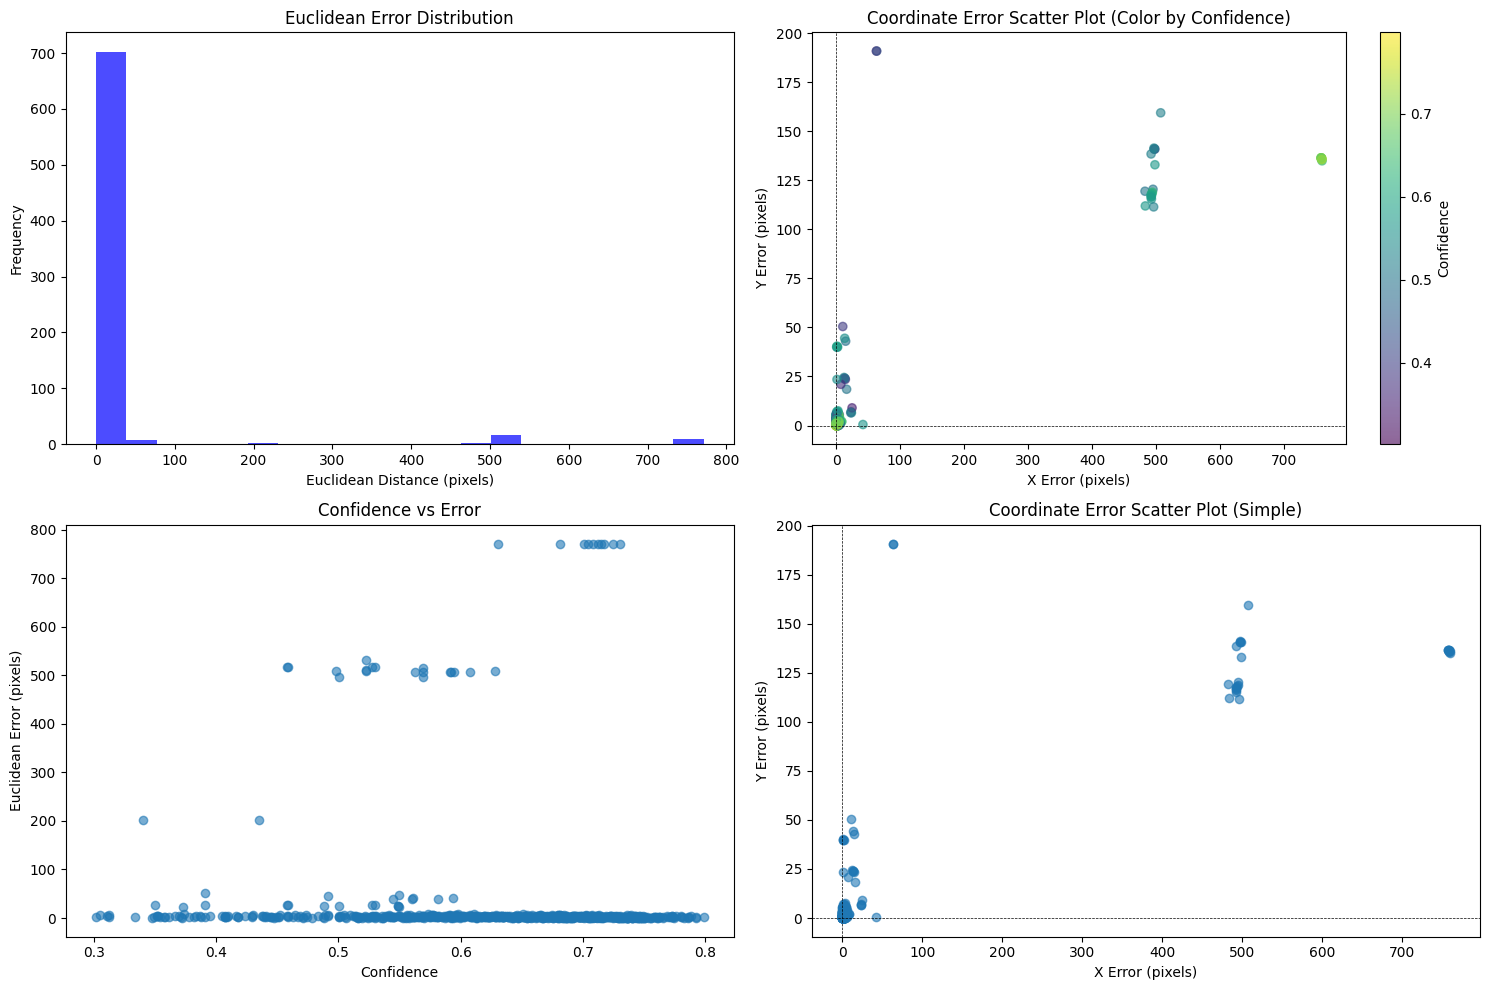


Saved results to 'yolo_error_analysis_results.csv' and 'yolo_error_stats_summary.csv'


In [3]:
import os
import cv2 
import numpy as np
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Paths
model_path = "/kaggle/input/yolov11-with-no-attention/runs/detect/motor_detector/weights/best.pt"
val_images_dir = "/kaggle/input/parse-data/yolo_dataset/images/val/"
val_labels_dir = "/kaggle/input/parse-data/yolo_dataset/labels/val/"

# Load YOLO model
model = YOLO(model_path)

results = []

for image_name in os.listdir(val_images_dir):
    if not image_name.endswith(('.jpg', '.png', '.jpeg')):
        continue
    
    # --- Ground Truth ---
    label_path = os.path.join(val_labels_dir, image_name.rsplit('.', 1)[0] + '.txt')
    try:
        with open(label_path, 'r') as f:
            gt_data = f.readline().strip().split()  # class x_center y_center w h
    except FileNotFoundError:
        print(f"Label missing for {image_name}, skipping")
        continue
    
    # --- Image Loading ---
    img_path = os.path.join(val_images_dir, image_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load {image_name}, skipping")
        continue
    
    img_height, img_width = img.shape[:2]
    
    # Convert YOLO format (normalized) to pixel coordinates
    x_gt = float(gt_data[1]) * img_width
    y_gt = float(gt_data[2]) * img_height

    # --- Prediction ---
    preds = model(img, verbose=False)[0]
    if len(preds.boxes) == 0:
        print(f"No motor detected in {image_name}")
        continue
    
    best_box = preds.boxes
    best_box_conf = best_box.conf.cpu().numpy()
    best_idx = np.argmax(best_box_conf)
    if best_box_conf[best_idx] < 0.3:
        continue
    
    x1, y1, x2, y2 = map(int, best_box.xyxy[0].cpu().numpy())
    x_pred = (x1 + x2) / 2
    y_pred = (y1 + y2) / 2
    
    euclidean_dist = np.sqrt((x_gt - x_pred)**2 + (y_gt - y_pred)**2)
    
    # --- Store Results ---
    results.append({
        'image': image_name,
        'x_gt': x_gt, 'y_gt': y_gt,
        'x_pred': x_pred, 'y_pred': y_pred,
        'error_x': abs(x_gt - x_pred),
        'error_y': abs(y_gt - y_pred),
        'euclidean_dist': euclidean_dist,
        'confidence': best_box_conf[best_idx],
        'class_id': best_box.cls[best_idx].item()
    })

# After processing all images...
if results:
    results_df = pd.DataFrame(results)
    
    # Calculate statistics
    stats = {
        'MAE_X': results_df['error_x'].mean(),
        'MAE_Y': results_df['error_y'].mean(),
        'MSE_X': np.mean(results_df['error_x']**2),
        'MSE_Y': np.mean(results_df['error_y']**2),
        'RMSE_X': np.sqrt(np.mean(results_df['error_x']**2)),
        'RMSE_Y': np.sqrt(np.mean(results_df['error_y']**2)),
        'Avg_Euclidean': results_df['euclidean_dist'].mean(),
        'MSE_Euclidean': np.mean(results_df['euclidean_dist']**2),
        'RMSE_Euclidean': np.sqrt(np.mean(results_df['euclidean_dist']**2)),
        'Avg_Confidence': results_df['confidence'].mean()
    }
    
    # Print statistics
    print("\n=== Coordinate-wise Errors ===")
    print(f"MAE (X): {stats['MAE_X']:.2f} pixels")
    print(f"MAE (Y): {stats['MAE_Y']:.2f} pixels")
    print(f"MSE (X): {stats['MSE_X']:.2f} px²")
    print(f"MSE (Y): {stats['MSE_Y']:.2f} px²")
    print(f"RMSE (X): {stats['RMSE_X']:.2f} pixels")
    print(f"RMSE (Y): {stats['RMSE_Y']:.2f} pixels")
    
    print("\n=== Combined Position Errors ===")
    print(f"Average Euclidean Distance: {stats['Avg_Euclidean']:.2f} pixels")
    print(f"MSE (Euclidean): {stats['MSE_Euclidean']:.2f} px²") 
    print(f"RMSE (Euclidean): {stats['RMSE_Euclidean']:.2f} pixels")
    print(f"\nAverage Confidence: {stats['Avg_Confidence']:.2f}")

    # Enhanced Visualizations
    plt.figure(figsize=(15, 10))
    
    # 1. Error distribution (original plot)
    plt.subplot(2, 2, 1)
    plt.hist(results_df['euclidean_dist'], bins=20, alpha=0.7, color='blue')
    plt.xlabel('Euclidean Distance (pixels)')
    plt.ylabel('Frequency')
    plt.title('Euclidean Error Distribution')
    
    # 2. Error scatter plot with confidence (enhanced)
    plt.subplot(2, 2, 2)
    plt.scatter(results_df['error_x'], results_df['error_y'], 
               c=results_df['confidence'], alpha=0.6, cmap='viridis')
    plt.colorbar(label='Confidence')
    plt.xlabel('X Error (pixels)')
    plt.ylabel('Y Error (pixels)')
    plt.title('Coordinate Error Scatter Plot (Color by Confidence)')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    
    # 3. Confidence vs Error (new plot)
    plt.subplot(2, 2, 3)
    plt.scatter(results_df['confidence'], results_df['euclidean_dist'], alpha=0.6)
    plt.xlabel('Confidence')
    plt.ylabel('Euclidean Error (pixels)')
    plt.title('Confidence vs Error')
    
    # 4. Class distribution (if multiple classes)
    if len(results_df['class_id'].unique()) > 1:
        plt.subplot(2, 2, 4)
        results_df['class_id'].value_counts().plot(kind='bar', alpha=0.7)
        plt.xlabel('Class ID')
        plt.ylabel('Count')
        plt.title('Class Distribution in Predictions')
    else:
        # Show original simple scatter plot if only one class
        plt.subplot(2, 2, 4)
        plt.scatter(results_df['error_x'], results_df['error_y'], alpha=0.6)
        plt.xlabel('X Error (pixels)')
        plt.ylabel('Y Error (pixels)')
        plt.title('Coordinate Error Scatter Plot (Simple)')
        plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
        plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_df.to_csv("yolo_error_analysis_results.csv", index=False)
    pd.DataFrame([stats]).to_csv("yolo_error_stats_summary.csv", index=False)
    print("\nSaved results to 'yolo_error_analysis_results.csv' and 'yolo_error_stats_summary.csv'")
else:
    print("No valid predictions to evaluate!")

No motor detected in tomo_53e048_z0194_y0666_x0542.jpg
No motor detected in tomo_37dd38_z0202_y0321_x0602.jpg
No motor detected in tomo_da79d8_z0206_y0184_x0492.jpg
No motor detected in tomo_738500_z0196_y0389_x0437.jpg
No motor detected in tomo_53e048_z0188_y0666_x0542.jpg
No motor detected in tomo_53e048_z0186_y0666_x0542.jpg
No motor detected in tomo_53e048_z0190_y0666_x0542.jpg
No motor detected in tomo_fd9357_z0129_y0364_x0138.jpg
No motor detected in tomo_4077d8_z0076_y0100_x0225.jpg
No motor detected in tomo_53e048_z0187_y0666_x0542.jpg
No motor detected in tomo_37dd38_z0187_y0303_x0593.jpg
No motor detected in tomo_3e7407_z0253_y0348_x0692.jpg
No motor detected in tomo_da79d8_z0235_y0186_x0492.jpg
No motor detected in tomo_37dd38_z0183_y0303_x0593.jpg
No motor detected in tomo_3e7407_z0245_y0350_x0725.jpg
No motor detected in tomo_da79d8_z0236_y0186_x0492.jpg
No motor detected in tomo_53e048_z0193_y0666_x0542.jpg
No motor detected in tomo_3e7407_z0254_y0348_x0692.jpg
No motor d

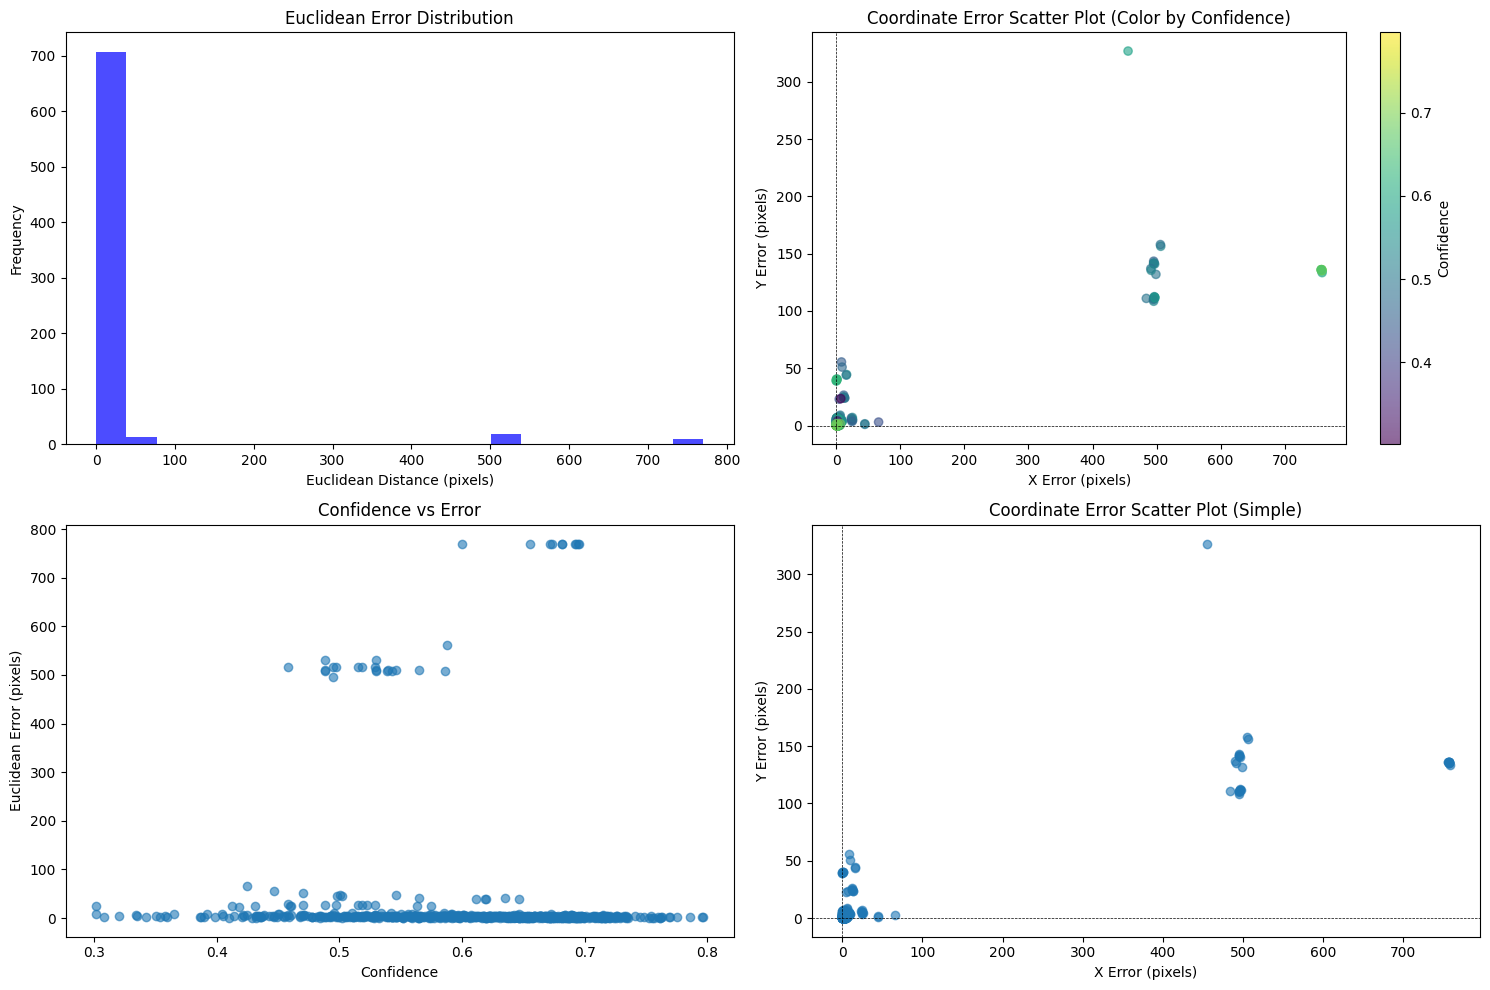


Saved results to 'yolo_error_analysis_results.csv' and 'yolo_error_stats_summary.csv'


In [4]:
import os
import cv2 
import numpy as np
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Paths
model_path = "/kaggle/input/yolov8n-100-epochs/other/default/1/yolov8n 100 epochs.pt"
val_images_dir = "/kaggle/input/parse-data/yolo_dataset/images/val/"
val_labels_dir = "/kaggle/input/parse-data/yolo_dataset/labels/val/"

# Load YOLO model
model = YOLO(model_path)

results = []

for image_name in os.listdir(val_images_dir):
    if not image_name.endswith(('.jpg', '.png', '.jpeg')):
        continue
    
    # --- Ground Truth ---
    label_path = os.path.join(val_labels_dir, image_name.rsplit('.', 1)[0] + '.txt')
    try:
        with open(label_path, 'r') as f:
            gt_data = f.readline().strip().split()  # class x_center y_center w h
    except FileNotFoundError:
        print(f"Label missing for {image_name}, skipping")
        continue
    
    # --- Image Loading ---
    img_path = os.path.join(val_images_dir, image_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load {image_name}, skipping")
        continue
    
    img_height, img_width = img.shape[:2]
    
    # Convert YOLO format (normalized) to pixel coordinates
    x_gt = float(gt_data[1]) * img_width
    y_gt = float(gt_data[2]) * img_height

    # --- Prediction ---
    preds = model(img, verbose=False)[0]
    if len(preds.boxes) == 0:
        print(f"No motor detected in {image_name}")
        continue
    
    best_box = preds.boxes
    best_box_conf = best_box.conf.cpu().numpy()
    best_idx = np.argmax(best_box_conf)
    if best_box_conf[best_idx] < 0.3:
        continue
    
    x1, y1, x2, y2 = map(int, best_box.xyxy[0].cpu().numpy())
    x_pred = (x1 + x2) / 2
    y_pred = (y1 + y2) / 2
    
    euclidean_dist = np.sqrt((x_gt - x_pred)**2 + (y_gt - y_pred)**2)
    
    # --- Store Results ---
    results.append({
        'image': image_name,
        'x_gt': x_gt, 'y_gt': y_gt,
        'x_pred': x_pred, 'y_pred': y_pred,
        'error_x': abs(x_gt - x_pred),
        'error_y': abs(y_gt - y_pred),
        'euclidean_dist': euclidean_dist,
        'confidence': best_box_conf[best_idx],
        'class_id': best_box.cls[best_idx].item()
    })

# After processing all images...
if results:
    results_df = pd.DataFrame(results)
    
    # Calculate statistics
    stats = {
        'MAE_X': results_df['error_x'].mean(),
        'MAE_Y': results_df['error_y'].mean(),
        'MSE_X': np.mean(results_df['error_x']**2),
        'MSE_Y': np.mean(results_df['error_y']**2),
        'RMSE_X': np.sqrt(np.mean(results_df['error_x']**2)),
        'RMSE_Y': np.sqrt(np.mean(results_df['error_y']**2)),
        'Avg_Euclidean': results_df['euclidean_dist'].mean(),
        'MSE_Euclidean': np.mean(results_df['euclidean_dist']**2),
        'RMSE_Euclidean': np.sqrt(np.mean(results_df['euclidean_dist']**2)),
        'Avg_Confidence': results_df['confidence'].mean()
    }
    
    # Print statistics
    print("\n=== Coordinate-wise Errors ===")
    print(f"MAE (X): {stats['MAE_X']:.2f} pixels")
    print(f"MAE (Y): {stats['MAE_Y']:.2f} pixels")
    print(f"MSE (X): {stats['MSE_X']:.2f} px²")
    print(f"MSE (Y): {stats['MSE_Y']:.2f} px²")
    print(f"RMSE (X): {stats['RMSE_X']:.2f} pixels")
    print(f"RMSE (Y): {stats['RMSE_Y']:.2f} pixels")
    
    print("\n=== Combined Position Errors ===")
    print(f"Average Euclidean Distance: {stats['Avg_Euclidean']:.2f} pixels")
    print(f"MSE (Euclidean): {stats['MSE_Euclidean']:.2f} px²") 
    print(f"RMSE (Euclidean): {stats['RMSE_Euclidean']:.2f} pixels")
    print(f"\nAverage Confidence: {stats['Avg_Confidence']:.2f}")

    # Enhanced Visualizations
    plt.figure(figsize=(15, 10))
    
    # 1. Error distribution (original plot)
    plt.subplot(2, 2, 1)
    plt.hist(results_df['euclidean_dist'], bins=20, alpha=0.7, color='blue')
    plt.xlabel('Euclidean Distance (pixels)')
    plt.ylabel('Frequency')
    plt.title('Euclidean Error Distribution')
    
    # 2. Error scatter plot with confidence (enhanced)
    plt.subplot(2, 2, 2)
    plt.scatter(results_df['error_x'], results_df['error_y'], 
               c=results_df['confidence'], alpha=0.6, cmap='viridis')
    plt.colorbar(label='Confidence')
    plt.xlabel('X Error (pixels)')
    plt.ylabel('Y Error (pixels)')
    plt.title('Coordinate Error Scatter Plot (Color by Confidence)')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    
    # 3. Confidence vs Error (new plot)
    plt.subplot(2, 2, 3)
    plt.scatter(results_df['confidence'], results_df['euclidean_dist'], alpha=0.6)
    plt.xlabel('Confidence')
    plt.ylabel('Euclidean Error (pixels)')
    plt.title('Confidence vs Error')
    
    # 4. Class distribution (if multiple classes)
    if len(results_df['class_id'].unique()) > 1:
        plt.subplot(2, 2, 4)
        results_df['class_id'].value_counts().plot(kind='bar', alpha=0.7)
        plt.xlabel('Class ID')
        plt.ylabel('Count')
        plt.title('Class Distribution in Predictions')
    else:
        # Show original simple scatter plot if only one class
        plt.subplot(2, 2, 4)
        plt.scatter(results_df['error_x'], results_df['error_y'], alpha=0.6)
        plt.xlabel('X Error (pixels)')
        plt.ylabel('Y Error (pixels)')
        plt.title('Coordinate Error Scatter Plot (Simple)')
        plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
        plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_df.to_csv("yolo_error_analysis_results.csv", index=False)
    pd.DataFrame([stats]).to_csv("yolo_error_stats_summary.csv", index=False)
    print("\nSaved results to 'yolo_error_analysis_results.csv' and 'yolo_error_stats_summary.csv'")
else:
    print("No valid predictions to evaluate!")

No detections in tomo_abb45a_z0153_y0748_x0688.jpg
No detections in tomo_abb45a_z0152_y0748_x0688.jpg

=== Coordinate-wise Errors ===
MAE (X): 22.54 pixels
MAE (Y): 8.11 pixels
MSE (X): 12530.53 px²
MSE (Y): 951.83 px²
RMSE (X): 111.94 pixels
RMSE (Y): 30.85 pixels

=== Combined Position Errors ===
Average Euclidean Distance: 25.26 pixels
MSE (Euclidean): 13482.36 px²
RMSE (Euclidean): 116.11 pixels

Average Confidence: 0.78


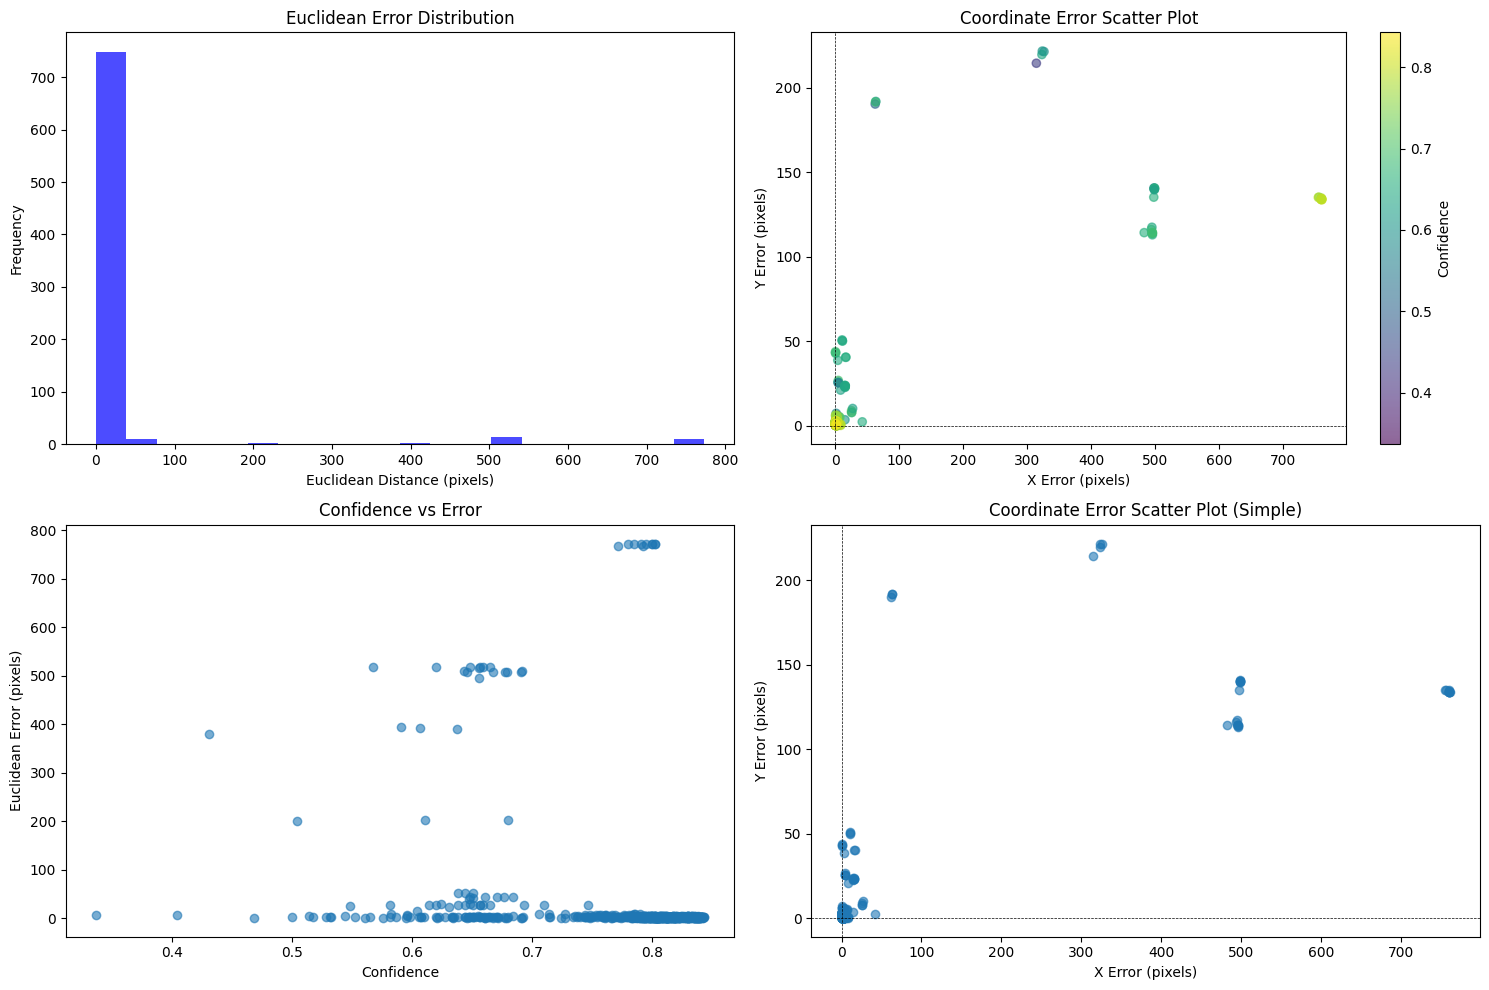


Saved results to 'rtdetr_error_analysis_results.csv' and 'rtdetr_error_stats_summary.csv'


In [5]:
import os
import cv2 
import numpy as np
import pandas as pd
from ultralytics import RTDETR
import matplotlib.pyplot as plt

# Paths
model_path = "/kaggle/input/detr-model/other/default/1/detr_best_model.pt"  # Replace with your model path
val_images_dir = "/kaggle/input/parse-data/yolo_dataset/images/val/"  # Path to validation images
val_labels_dir = "/kaggle/input/parse-data/yolo_dataset/labels/val/"  # Path to YOLO-format labels

# Load model
model = RTDETR(model_path)

results = []

for image_name in os.listdir(val_images_dir):
    if not image_name.endswith(('.jpg', '.png', '.jpeg')):
        continue
    
    # --- Ground Truth ---
    label_path = os.path.join(val_labels_dir, image_name.rsplit('.', 1)[0] + '.txt')
    try:
        with open(label_path, 'r') as f:
            gt_data = f.readline().strip().split()  # class x_center y_center w h
    except FileNotFoundError:
        print(f"Label missing for {image_name}, skipping")
        continue
    
    # --- Image Loading ---
    img_path = os.path.join(val_images_dir, image_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load {image_name}, skipping")
        continue
    
    img_height, img_width = img.shape[:2]
    
    # Convert YOLO format (normalized) to pixel coordinates
    x_gt = float(gt_data[1]) * img_width
    y_gt = float(gt_data[2]) * img_height

    # --- Prediction ---
    results_pred = model.predict(img, verbose=False)[0]
    
    # RT-DETR specific output handling
    if len(results_pred.boxes) == 0:
        print(f"No detections in {image_name}")
        continue
    
    # Get all predictions (RT-DETR returns all predictions sorted by confidence)
    boxes = results_pred.boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2] format
    confidences = results_pred.boxes.conf.cpu().numpy()
    class_ids = results_pred.boxes.cls.cpu().numpy()
    
    # Select the highest confidence detection
    best_idx = np.argmax(confidences)
    best_conf = confidences[best_idx]
    
    if best_conf < 0.3:  # Confidence threshold
        continue
        
    best_box = boxes[best_idx]
    x1, y1, x2, y2 = best_box
    x_pred = (x1 + x2) / 2
    y_pred = (y1 + y2) / 2
    
    # Calculate errors
    error_x = abs(x_gt - x_pred)
    error_y = abs(y_gt - y_pred)
    euclidean_dist = np.sqrt(error_x**2 + error_y**2)
    
    # --- Store Results ---
    results.append({
        'image': image_name,
        'x_gt': x_gt, 'y_gt': y_gt,
        'x_pred': x_pred, 'y_pred': y_pred,
        'error_x': error_x,
        'error_y': error_y,
        'euclidean_dist': euclidean_dist,
        'confidence': best_conf,
        'class_id': class_ids[best_idx]
    })

# After processing all images...

if results:
    results_df = pd.DataFrame(results)
    
    # Calculate statistics
    stats = {
        'MAE_X': results_df['error_x'].mean(),
        'MAE_Y': results_df['error_y'].mean(),
        'MSE_X': np.mean(results_df['error_x']**2),
        'MSE_Y': np.mean(results_df['error_y']**2),
        'RMSE_X': np.sqrt(np.mean(results_df['error_x']**2)),
        'RMSE_Y': np.sqrt(np.mean(results_df['error_y']**2)),
        'Avg_Euclidean': results_df['euclidean_dist'].mean(),
        'MSE_Euclidean': np.mean(results_df['euclidean_dist']**2),
        'RMSE_Euclidean': np.sqrt(np.mean(results_df['euclidean_dist']**2)),
        'Avg_Confidence': results_df['confidence'].mean()
    }
    
    # Print statistics
    print("\n=== Coordinate-wise Errors ===")
    print(f"MAE (X): {stats['MAE_X']:.2f} pixels")
    print(f"MAE (Y): {stats['MAE_Y']:.2f} pixels")
    print(f"MSE (X): {stats['MSE_X']:.2f} px²")
    print(f"MSE (Y): {stats['MSE_Y']:.2f} px²")
    print(f"RMSE (X): {stats['RMSE_X']:.2f} pixels")
    print(f"RMSE (Y): {stats['RMSE_Y']:.2f} pixels")
    
    print("\n=== Combined Position Errors ===")
    print(f"Average Euclidean Distance: {stats['Avg_Euclidean']:.2f} pixels")
    print(f"MSE (Euclidean): {stats['MSE_Euclidean']:.2f} px²") 
    print(f"RMSE (Euclidean): {stats['RMSE_Euclidean']:.2f} pixels")
    print(f"\nAverage Confidence: {stats['Avg_Confidence']:.2f}")

    # Visualizations
    plt.figure(figsize=(15, 10))
    
    # Error distribution
    plt.subplot(2, 2, 1)
    plt.hist(results_df['euclidean_dist'], bins=20, alpha=0.7, color='blue')
    plt.xlabel('Euclidean Distance (pixels)')
    plt.ylabel('Frequency')
    plt.title('Euclidean Error Distribution')
    
    # Error scatter plot
    plt.subplot(2, 2, 2)
    plt.scatter(results_df['error_x'], results_df['error_y'], 
               c=results_df['confidence'], alpha=0.6, cmap='viridis')
    plt.colorbar(label='Confidence')
    plt.xlabel('X Error (pixels)')
    plt.ylabel('Y Error (pixels)')
    plt.title('Coordinate Error Scatter Plot')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    
    # Confidence vs Error
    plt.subplot(2, 2, 3)
    plt.scatter(results_df['confidence'], results_df['euclidean_dist'], alpha=0.6)
    plt.xlabel('Confidence')
    plt.ylabel('Euclidean Error (pixels)')
    plt.title('Confidence vs Error')

    
    # 4. Class distribution (if multiple classes)
    if len(results_df['class_id'].unique()) > 1:
        plt.subplot(2, 2, 4)
        results_df['class_id'].value_counts().plot(kind='bar', alpha=0.7)
        plt.xlabel('Class ID')
        plt.ylabel('Count')
        plt.title('Class Distribution in Predictions')
    else:
        # Show original simple scatter plot if only one class
        plt.subplot(2, 2, 4)
        plt.scatter(results_df['error_x'], results_df['error_y'], alpha=0.6)
        plt.xlabel('X Error (pixels)')
        plt.ylabel('Y Error (pixels)')
        plt.title('Coordinate Error Scatter Plot (Simple)')
        plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
        plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_df.to_csv("rtdetr_error_analysis_results.csv", index=False)
    pd.DataFrame([stats]).to_csv("rtdetr_error_stats_summary.csv", index=False)
    print("\nSaved results to 'rtdetr_error_analysis_results.csv' and 'rtdetr_error_stats_summary.csv'")
else:
    print("No valid predictions to evaluate!")